<div class="alert alert-success">
        <h1 align="center" style="color:darkcyan;">Unet Model For Image Segmentation
</h1>  
     
</div>

<div class="alert alert-success">
        <h1 align="center" style="color:darkcyan;">Import Libraries and Dependecy
</h1>  
     
</div>

In [16]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path
import random
import glob
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div class="alert alert-success">
        <h1 align="center" style="color:darkcyan;">Reading The data
</h1>  
     
</div>

In [18]:
image_path = '/content/drive/MyDrive/data/road/images'
mask_path  = '/content/drive/MyDrive/data/road/masks'

<div class="alert alert-success">
        <h1 align="center" style="color:darkcyan;">Function to display the images
</h1>  
     
</div>

In [19]:
def display_image(image_folder):

    image_files = [f for f in (os.listdir(image_folder)) if f.endswith(('jpg','png','jpeg'))]

    fig,axes = plt.subplots(3,3,figsize=(10,10))

    for i, file_name in enumerate(image_files):

        if i>=9:
            break
        row = i//3
        col = i%3

        image_path = os.path.join(image_folder, file_name)
        image = cv2.imread(image_path)
        axes[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[row, col].set_title(file_name)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


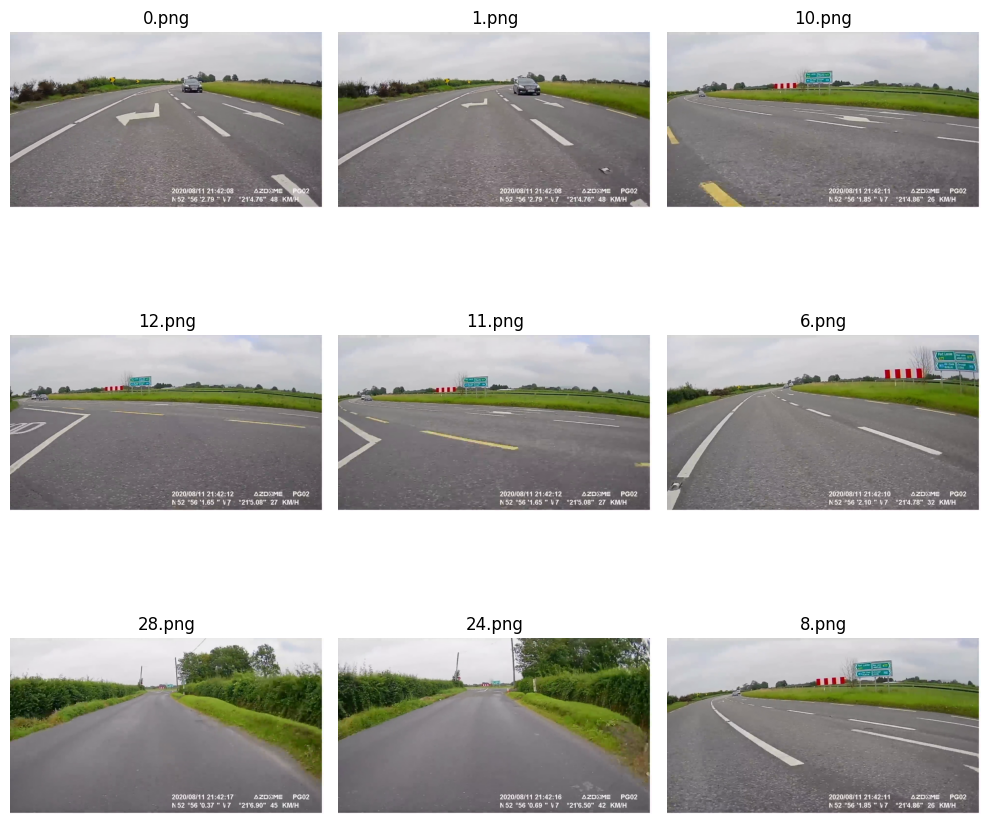

In [20]:
image_folder = '/content/drive/MyDrive/data/road/images'
display_image(image_folder)

<div class="alert alert-success">
        <h1 align="center" style="color:darkcyan;">Function to display Mask
</h1>  
     
</div>

In [21]:
def mask_image(image_folder):

    image_files = [f for f in (os.listdir(image_folder)) if f.endswith(('jpg','png','jpeg'))]

    fig,axes = plt.subplots(3,3,figsize=(10,10))

    for i, file_name in enumerate(image_files):

        if i>=9:
            break
        row = i//3
        col = i%3

        image_path = os.path.join(image_folder, file_name)
        image = cv2.imread(image_path)
        axes[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[row, col].set_title(file_name)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

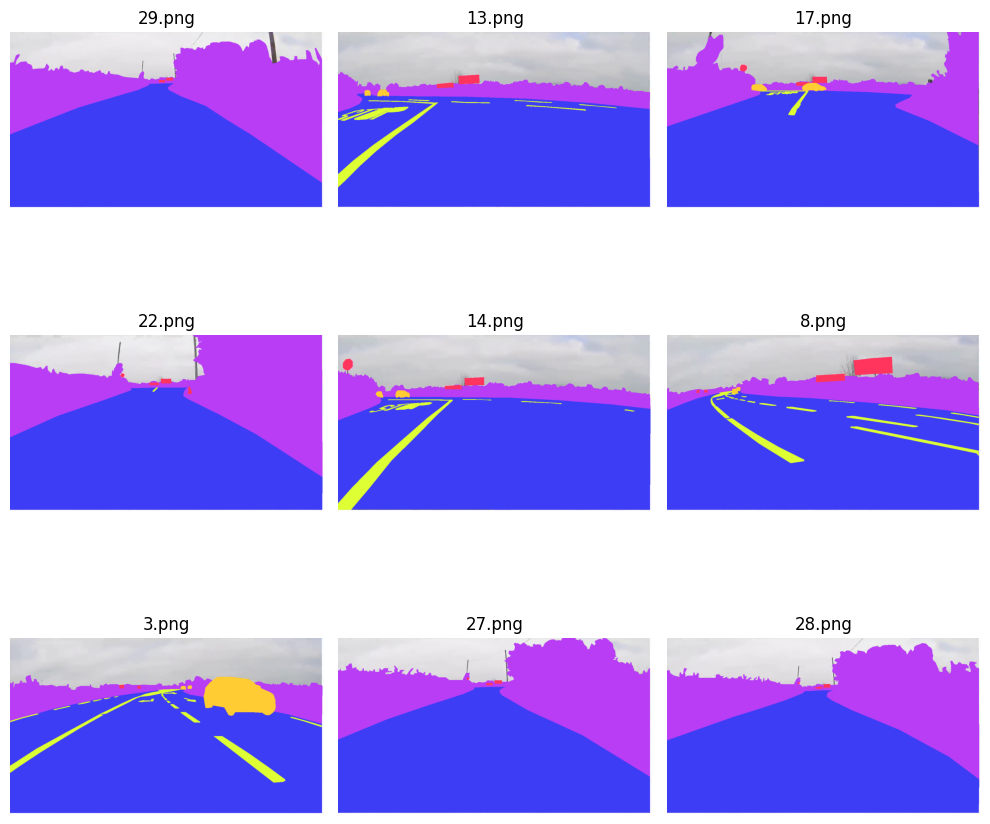

In [22]:
image_folder = '/content/drive/MyDrive/data/road/masks'
mask_image(image_folder)

In [23]:
image_path = "//content/drive/MyDrive/data/road/images/*.png"
mask_path = "/content/drive/MyDrive/data/road/masks/*.png"
image_paths = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_paths = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

In [24]:
def resize_image(image, size):
    resized_image = cv2.resize(image, size)
    return resized_image

def resize_mask(mask, size):
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    resized_mask = cv2.resize(mask_gray, size, interpolation=cv2.INTER_NEAREST)
    resized_mask = np.expand_dims(resized_mask, axis=2)
    return resized_mask

In [25]:
target_size = (512,512)
image_list = []
mask_list = []
for image_path, mask_path in zip(image_paths, mask_paths):
    image = plt.imread(image_path).astype(np.float32)
    mask = plt.imread(mask_path).astype(np.float32)

    resized_image = resize_image(image, target_size)
    resized_mask = resize_mask(mask, target_size)

    image_list.append(resized_image)
    mask_list.append(resized_mask)

image_array = np.array(image_list)
mask_array = np.array(mask_list)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_array,mask_array, test_size=0.2, random_state=23)

In [27]:
import tensorflow as tf

def create_unet_model(input_shape=(512, 512, 3)):
    x = tf.keras.layers.Input(input_shape)

    enc1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    enc2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(enc1)
    enc3 = tf.keras.layers.MaxPooling2D((2, 2))(enc2)
    enc3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(enc3)
    enc4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(enc3)
    enc5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(enc4)
    enc6 = tf.keras.layers.MaxPooling2D((2, 2))(enc5)
    enc6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(enc6)
    enc7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(enc6)
    enc8 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='relu')(enc7)

    skip1 = enc2
    skip2 = enc5

    dec1 = tf.keras.layers.UpSampling2D((2, 2))(enc8)
    dec1 = tf.keras.layers.Concatenate()([dec1, skip2])
    dec1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(dec1)
    dec1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(dec1)

    dec2 = tf.keras.layers.UpSampling2D((2, 2))(dec1)
    dec2 = tf.keras.layers.Concatenate()([dec2, skip1])
    dec2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(dec2)
    dec2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(dec2)

    dec3 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(dec2)

    model = tf.keras.Model(inputs=x, outputs=dec3)
    return model

In [28]:
model = create_unet_model()

In [29]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [30]:
history = model.fit(X_train,y_train, batch_size=8, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 106s 14s/step - accuracy: 0.0010 - loss: 0.6916 - val_accuracy: 0.0020 - val_loss: 0.6889
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.0024 - loss: 0.6862 - val_accuracy: 0.0020 - val_loss: 0.6787
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0025 - loss: 0.6810 - val_accuracy: 0.0020 - val_loss: 0.6806
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0024 - loss: 0.6752 - val_accuracy: 0.0020 - val_loss: 0.6645
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0024 - loss: 0.6541 - val_accuracy: 0.0020 - val_loss: 0.6244


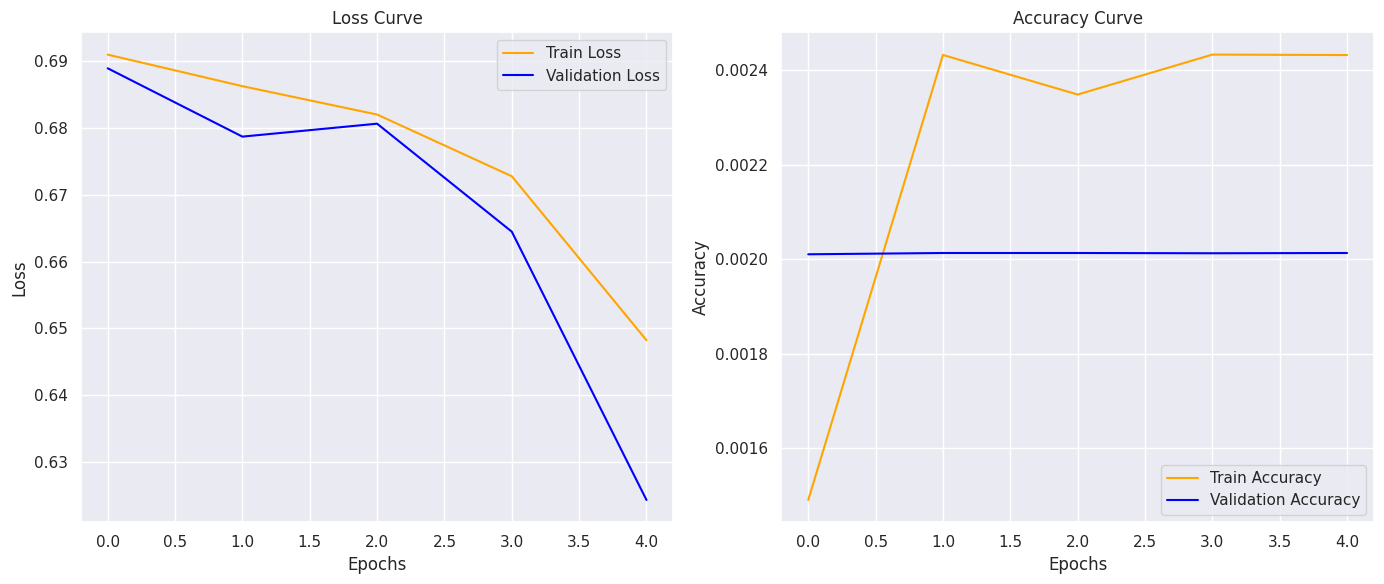

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(history.history['loss'], c='orange', label='Train Loss')
axes[0].plot(history.history['val_loss'], c='blue', label='Validation Loss')
axes[0].set_title("Loss Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(history.history['accuracy'], c='orange', label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], c='blue', label='Validation Accuracy')
axes[1].set_title("Accuracy Curve")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


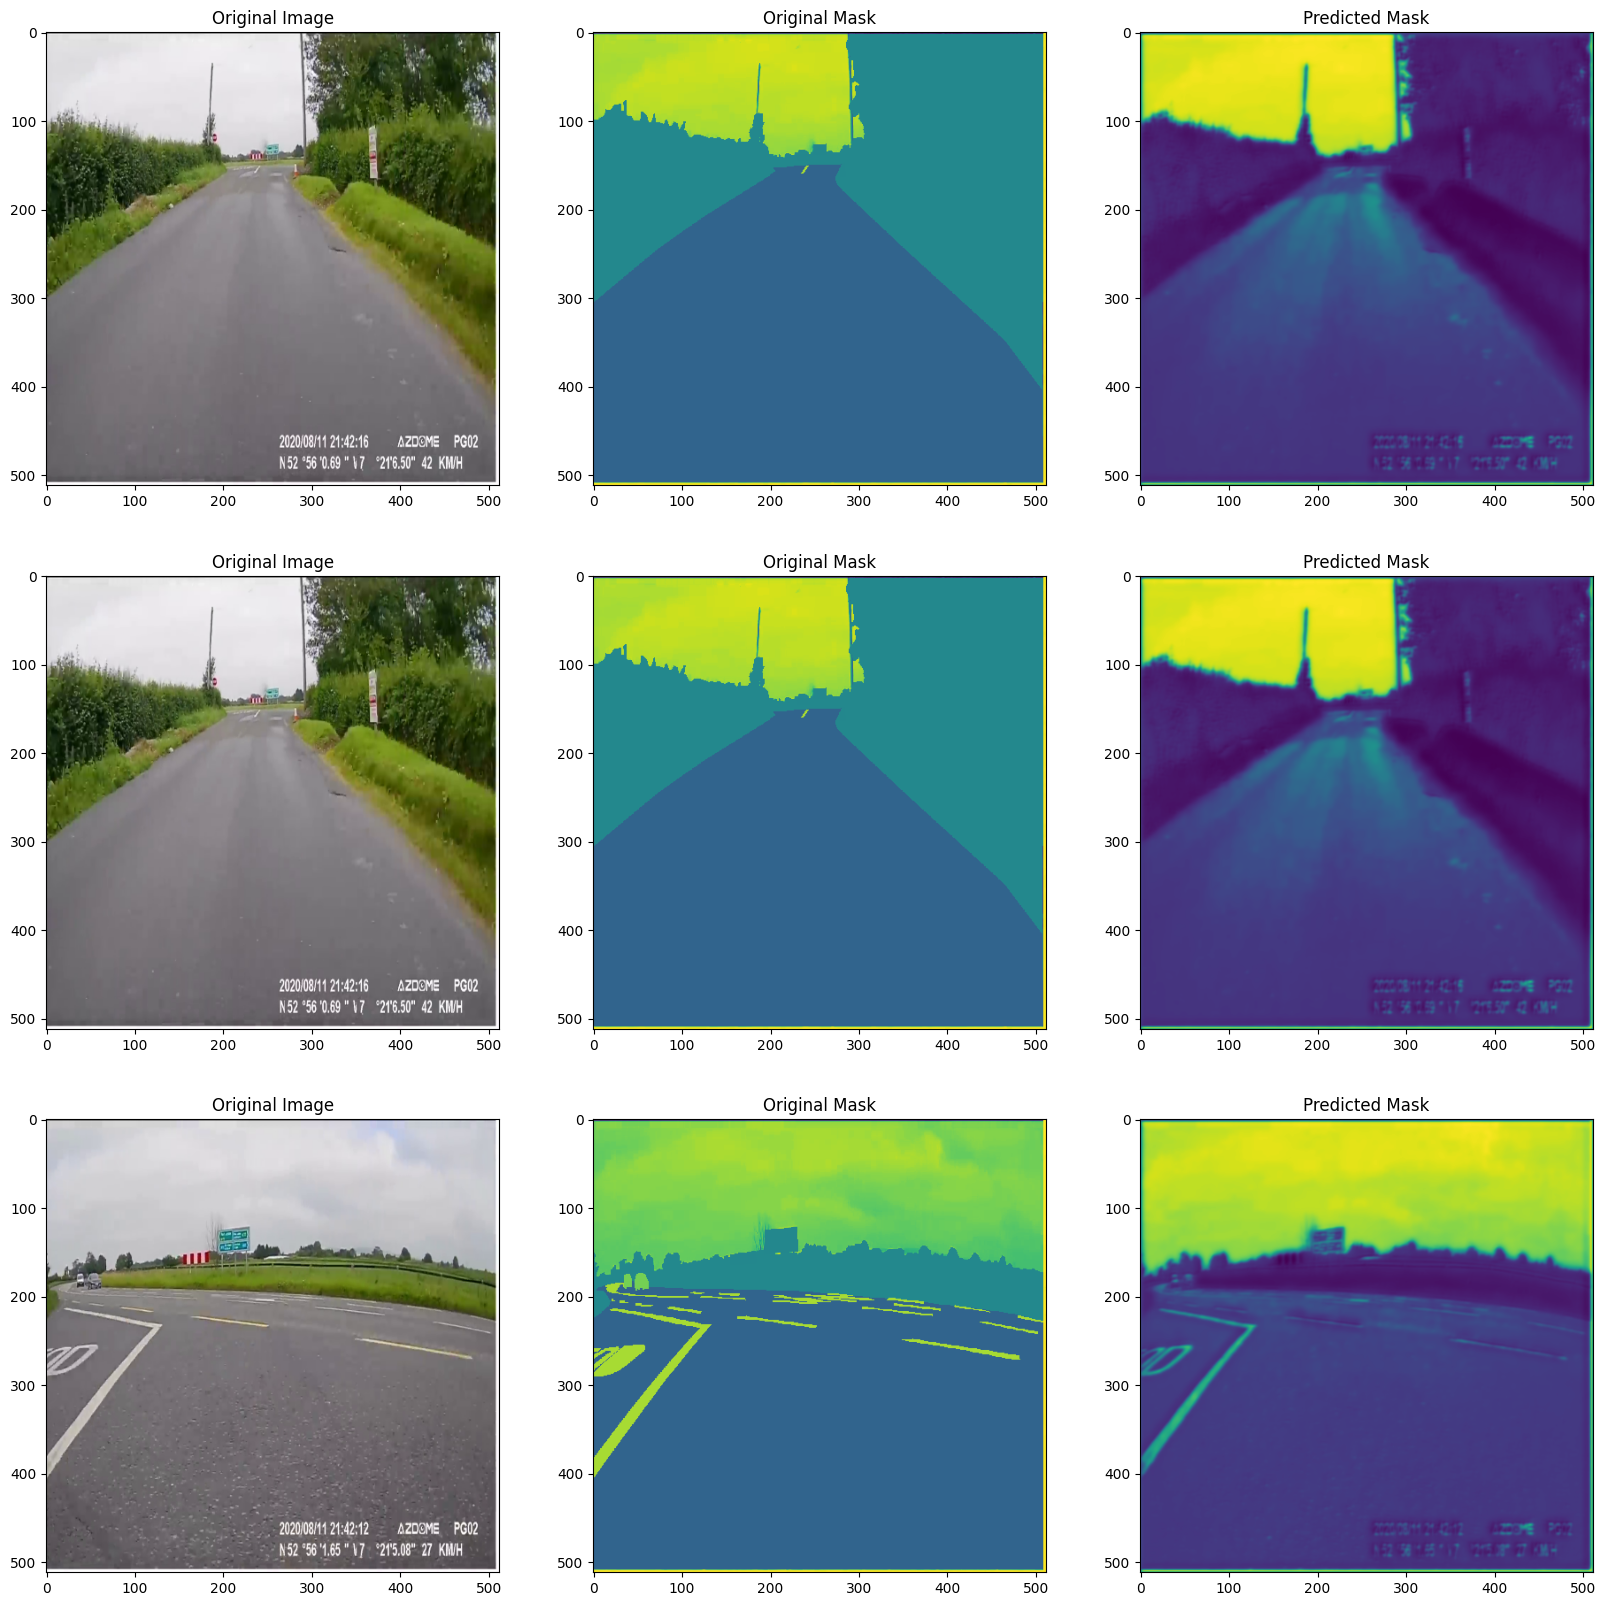

In [31]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,5)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')

    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')

    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(512,512)
    axes[i,2].imshow(predicted_mask)
    axes[i,2].title.set_text('Predicted Mask')